In [ ]:
import torch
import torchaudio

In [ ]:
path = '/scratch/bbje/battula12/Databases/SourceTrajectories/config_dict_1.pt'

In [ ]:
cfg_dict = torch.load(path)

In [ ]:
cfg_dict

In [ ]:
room_sz = cfg_dict['room_sz']
src_pos = cfg_dict['src_traj_pts']

In [ ]:
room_sz

In [ ]:
src_pos

In [ ]:
class SegSplitter:

	def __init__(self, seg_size, seg_shift):
		self.kernel = (1,seg_size)
		self.stride = (1,seg_shift)

	def __call__(self, x):
		#assuming x.shape ( 2,*)
		x = x.unsqueeze(dim=1).unsqueeze(dim=1) #reshape required for unfold
		x_segs = torch.nn.functional.unfold(x, self.kernel, padding=(0,0), stride=self.stride)
		x_segs = torch.permute(x_segs, [2,0,1])  #( n_segs, 2 , seg_size)
		x_segs = torch.reshape(x_segs,[x_segs.shape[0]*x_segs.shape[1], x_segs.shape[2]]) #( n_segs*2 , seg_size)
		return x_segs  

In [ ]:
x, fs = torchaudio.load('/scratch/bbje/battula12/Databases/LibriSpeech/LibriSpeech/train-clean-100/19/227/19-227-0031.flac')

In [ ]:
seg_split = SegSplitter(64000,16000)

In [ ]:
x_2 = torch.cat((x,x), dim=0)

In [ ]:
x_2.shape

In [ ]:
segs = seg_split(x_2)

In [ ]:
segs.shape

In [ ]:
doa = x_2
doa_seg = seg_split(doa)
doa_seg = doa_seg.unsqueeze(dim=1).unsqueeze(dim=1) #reshape required for unfold
print(doa_seg.shape)
doa_frm = torch.nn.functional.unfold(doa_seg, (1,320), padding=(0,0), stride=(1,160))

doa_frm = torch.mode(doa_frm, dim=1).values

print(doa_frm.shape)

doa_frm = doa_frm.reshape(doa_frm.shape[0]//2, 2, doa_frm.shape[1])
doa_frm = torch.permute(doa_frm, [0,2,1])

In [ ]:
doa_frm.shape

In [ ]:
len(x_2)

In [ ]:
with open('dataset_file.txt', 'r') as f:
    tr_ex_list = [line.strip().split(',')[0] for line in f.readlines()]

In [ ]:
min_sig_len = 200
for idx, ex in enumerate(tr_ex_list):
    x, fs = torchaudio.load(ex)
    if fs != 16000:
        print(idx, ex)
    sig_len = x.shape[1] // fs
    min_sig_len = sig_len if sig_len < min_sig_len else min_sig_len

In [ ]:
min_sig_len

In [ ]:
import torch
import torchaudio
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import webrtcvad
import soundfile
import random
from collections import namedtuple
from utils import Parameter
from locata_utils import *

In [ ]:
!salloc --nodes=1 --gpus-per-node=1 --cpus-per-task=28 -A bbje-delta-gpu --time 1:0:0

In [ ]:
!ssh gpua002

In [ ]:

import gpuRIR
#from AcousticScene import AcousticScene

In [ ]:
#Experiment to see which metrics are showing sensitivity to impulse response change


ArraySetup = namedtuple('ArraySetup', 'arrayType, orV, mic_pos, mic_orV, mic_pattern')
array_setup_10cm_2mic = ArraySetup(arrayType='planar', 
								orV = np.array([0.0, 1.0, 0.0]),
								mic_pos = np.array((( 0.05,  0.000, 0.000),
													(-0.05,  0.000, 0.000))), 
								mic_orV = np.array(((0.0, 1.0, 0.0),
													(0.0, 1.0, 0.0))), 
								mic_pattern = 'omni'
                        )

In [ ]:


import numpy as np
src_pos_ini = 160 
src_pos_end = 10
nb_points = 16
#uniform sampling code for theta
x = np.linspace(160,10,nb_points)

#traj_pts = np.array([np.linspace(i,j,nb_points) for i,j in zip(src_pos_ini, src_pos_end)]).transpose()

In [ ]:
x

In [ ]:
def get_pos( r, azimuth):
		src_pos = np.array([r*np.cos(azimuth), r*np.sin(azimuth), 0.0])
		return src_pos
v = [get_pos(1,np.deg2rad(i)) for i in x]

In [ ]:
np.array(v).shape


In [ ]:
x.shape

In [1]:
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D

def plotScene(room_sz, mic_pos, traj_pts, noise_pos, T60, SNR, view='3D'):
		""" Plots the source trajectory and the microphones within the room
		"""
		assert view in ['3D', 'XYZ', 'XY', 'XZ', 'YZ']

		fig = plt.figure()

		if view == '3D' or view == 'XYZ':
			ax = Axes3D(fig)
			ax.set_xlim3d(0, room_sz[0])
			ax.set_ylim3d(0, room_sz[1])
			ax.set_zlim3d(0, room_sz[2])

			ax.scatter(traj_pts[:,0], traj_pts[:,1], traj_pts[:,2])
			ax.scatter(mic_pos[:,0], mic_pos[:,1], mic_pos[:,2])
			ax.text(traj_pts[0,0], traj_pts[0,1], traj_pts[0,2], 'start')

			ax.set_title('$T_{60}$' + ' = {:.3f}s, SNR = {:.1f}dB'.format(T60, SNR))
			ax.set_xlabel('x [m]')
			ax.set_ylabel('y [m]')
			ax.set_zlabel('z [m]')

		else:
			ax = fig.add_subplot(111)
			plt.gca().set_aspect('equal', adjustable='box')

			if view == 'XY':
				ax.set_xlim(0, room_sz[0])
				ax.set_ylim(0, room_sz[1])
				ax.scatter(traj_pts[:,0], traj_pts[:,1])
				ax.scatter(noise_pos[:,0], noise_pos[:,1])
				ax.scatter(mic_pos[:,0], mic_pos[:,1])
				ax.text(traj_pts[0,0], traj_pts[0,1], 'start')
				ax.legend(['Source trajectory', 'Noise pos', 'Microphone array'])
				ax.set_xlabel('x [m]')
				ax.set_ylabel('y [m]')
			elif view == 'XZ':
				ax.set_xlim(0, room_sz[0])
				ax.set_ylim(0, room_sz[2])
				ax.scatter(traj_pts[:,0], traj_pts[:,2])
				ax.scatter(mic_pos[:,0], mic_pos[:,2])
				ax.text(traj_pts[0,0], traj_pts[0,2], 'start')
				ax.legend(['Source trajectory', 'Microphone array'])
				ax.set_xlabel('x [m]')
				ax.set_ylabel('z [m]')
			elif view == 'YZ':
				ax.set_xlim(0, room_sz[1])
				ax.set_ylim(0, room_sz[2])
				ax.scatter(traj_pts[:,1], traj_pts[:,2])
				ax.scatter(mic_pos[:,1], mic_pos[:,2])
				ax.text(traj_pts[0,1], traj_pts[0,2], 'start')
				ax.legend(['Source trajectory', 'Microphone array'])
				ax.set_xlabel('y [m]')
				ax.set_ylabel('z [m]')

		plt.show()

In [2]:
from TestDataset import *
# Named tuple with the characteristics of a microphone array and definitions of the LOCATA arrays:
ArraySetup = namedtuple('ArraySetup', 'arrayType, orV, mic_pos, mic_orV, mic_pattern')

array_setup_10cm_2mic = ArraySetup(arrayType='planar', 
                                    orV = np.array([0.0, 1.0, 0.0]),
                                    mic_pos = np.array((( 0.05,  0.000, 0.000),
                                                        (-0.05,  0.000, 0.000))), 
                                    mic_orV = np.array(((0.0, 1.0, 0.0),
                                                        (0.0, 1.0, 0.0))), 
                                    mic_pattern = 'omni'
                                )
test_config = TestConfig(array_setup=array_setup_10cm_2mic, test_snr=5, test_t60=0.2, static_prob=0.0, src_mic_dist = 1.0, non_linear_prob=0.0, nb_points=16, same_plane=True)

static_config_dict = test_config._create_acoustic_scene_config("Static")
circular_motion_config_dict = test_config._create_acoustic_scene_config("CircularMotion")

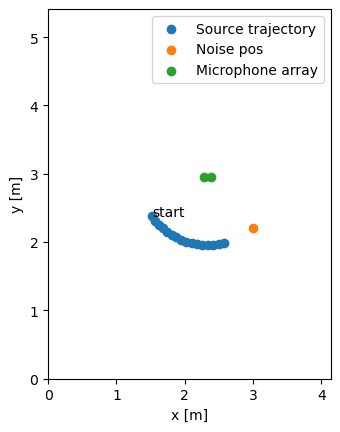

In [3]:
config_dict = circular_motion_config_dict
room_sz = config_dict['room_sz']
mic_pos = config_dict['mic_pos']
traj_pts= config_dict['src_traj_pts']
noise_pos= config_dict['noise_pos']
T60= config_dict['t60']
SNR= config_dict['snr']

plotScene(room_sz, mic_pos, traj_pts, noise_pos, T60, SNR, view='XY')

In [12]:
config_dict

{'snr': array(5),
 't60': array(0.2),
 'room_sz': array([3.03529807, 6.97103937, 2.70914202]),
 'abs_weights': array([0.8652544 , 0.6463547 , 0.9092834 , 0.9407179 , 0.64268152,
        0.64537329]),
 'mic_pos': array([[1.44408962, 3.8521247 , 1.20174504],
        [1.34408962, 3.8521247 , 1.20174504]]),
 'array_pos': array([1.39408962, 3.8521247 , 1.20174504]),
 'src_traj_pts': array([[2.37676147, 3.66677091, 1.20174504]]),
 'noise_pos': array([[2.17672189, 3.22964037, 1.20174504]]),
 'nb_points': 1}